# SIMPACK Cartographic Track 示例思路和代码
- 实现了各分段（STR/CIR/BLO）的曲率函数 κ(s)，并在分段交界处用一段“平滑区”保证二阶导数的连续——这与 SIMPACK 的“Bloss + smoothing”原理相似，可以在整个里程范围内得到一条更光滑、与 SIMPACK 结果更贴合的 κ(s)
- 最后对曲率做数值积分，即可获得轨道在平面内的坐标；若再加上竖向坡度、超高等，也能扩展到 3D 轨道

## 提示
1. 下述代码依然是“示例”，并未 100% 复刻 SIMPACK 的所有插值细节；尤其在 Bloss 与 smoothing 同处一段时，SIMPACK 可能还包含其他工程上累积的经验规则
2. 然而，本示例已体现用分段多项式在段交界处做无缝拼接的关键思路，能够在多数应用中和 SIMPACK 原生结果达到极高的一致度
3. 代码示例只对“水平曲率κ”演示了完整的拼接；若要处理超高 𝑢(𝑠)，请使用相同的逻辑（把 κ 换成 u 即可）

# 整体思路
## 1. 原始分段函数
在 Cartographic Track 的每段，都可以先写出一个原始曲率公式 κ_raw(s)：
- STR 段：κ=0
- CIR 段：κ=1/R​（常数）
- BLO 段（Bloss 过渡曲线）
  $\kappa(s) = \kappa_1 + (\kappa_2 - \kappa_1) \cdot (3x^2 - 2x^3), \quad x = \frac{s}{L_\mathrm{seg}}$。

其中, $\kappa_1 = \frac{1}{R_1}, \quad \kappa_2 = \frac{1}{R_2}$。
例如，若一段声明 ('BLO',50,0,300)，则表示“Bloss 过渡曲线长度 50m，初末曲率分别 0 和 1/300”。

## 2. 分段连接 + Smoothing

SIMPACK 提供一个"平滑总长度" $L_{\mathrm{smo}}$（常见取 2 m ～ 5 m 或更小）来**数值上**保证相邻两段衔接时的**高阶连续**：

* 在分段 $i$ 和 $i+1$ 的边界 $s_i$ 附近，**各留一半 $L_{\mathrm{smo}}/2$ 给平滑过渡**。
* 这部分平滑区并**不**额外增加段长，而是**覆盖**了分段的首尾各 $L_{\mathrm{smo}}/2$ 范围。
* 用一条**5 次多项式**在 $[\,s_i - L_{\mathrm{smo}}/2,\; s_i + L_{\mathrm{smo}}/2\,]$ 上插值，使其与前后段的"原始" $\kappa_{\mathrm{raw}}$ 的 $\kappa$、$\kappa'$、$\kappa''$ 在边界上保持一致，从而保证 $\mathcal{C}^2$ 光滑。

这样，一条具名义长度 $L_{\mathrm{seg}}$ 的 Bloss 段，其真正用于「Bloss 公式」的区间只剩 $(L_{\mathrm{seg}} - L_{\mathrm{smo}})$；首尾的 $L_{\mathrm{smo}}/2$ 用于 polynomial smoothing。**结果**：

* 总长仍是 $L_{\mathrm{seg}}$，但在内部融合了 Bloss 与 smoothing 的小段。
* 段与段之间二阶导数连续，避免了"反复过渡"所带来的偏移累积。

## 3. 生成全局 $\kappa(s)$ 函数

* 将**所有**段（STR/CIR/BLO）加上其**前后 smoothing** "拼"起来后，就得到一个从 $s=0$ 到 $s=L_{\mathrm{total}}$ 的分段式函数 $\kappa_{\mathrm{global}}(s)$。
* 同理，可对超高 $u(s)$ 或竖向坡度 $p(s)$ 做类似的 piecewise + smoothing 处理。

## 4. 数值积分得到 $(x(s),\,y(s))$

一旦有了 $\kappa_{\mathrm{global}}(s)$，我们即可做**航向角** $\psi$ 的积分：$\frac{d\psi}{ds} \;=\;\kappa(s) \quad\Longrightarrow\quad \psi(s)\;=\;\int_0^s \kappa(\tau)\,d\tau.$

然后在平面内积分坐标：$\frac{dx}{ds} = \cos\bigl[\psi(s)\bigr], \qquad \frac{dy}{ds} = \sin\bigl[\psi(s)\bigr].$

若仅考虑水平面（无竖曲线），则可令 $z=0$。若要考虑**坡度** $p(s)$，再做一次积分 $z'(s)=p(s)$ 得到 $z(s)$。

## 5. 左右钢轨 + 3D

* 如果还要得到左右钢轨的 3D 坐标，可先在每个 $s$ 点计算**超高** $u(s)$ 并转换成横滚角 $\phi(s)=\arcsin\!\bigl[u(s)/b_{\mathrm{ref}}\bigr]$。
* 然后，以中心线为基准，在局部坐标 $(y_{\mathrm{local}},\,z_{\mathrm{local}})$ 上做 $\pm b_{\mathrm{ref}}/2$ 与 $\pm u/2$ 的偏移，通过 $\psi(s)$ 和 $\phi(s)$ 转回全局，便能得到左右股钢轨或轮轨实际位置。
* 在已封装的 Python 代码中，这往往体现在"left_rail"与"right_rail"的计算环节中。

## 小结

1. **"Bloss + smoothing"** 的关键是：smoothing 并不额外拉长段，而是**占用**分段首尾的小范围，用高阶多项式衔接前后段的曲率及其导数。
2. 在此思路下，**整条轨道**得到一个二阶（甚至三阶）连续的 $\kappa(s)$ 函数，避免了"重复过渡"或"段间不连续"导致的误差累积。
3. **示例代码**（参考 xxx.py）中，演示了如何将**原始 Bloss** 段 + **多项式平滑**合并到一起，并通过数值积分得到平面曲线；可按同理处理超高、竖曲线等需求。
4. 由于 SIMPACK 还可能在极端工况（小半径、陡坡、大超高）时有其他内部修正，若需与其"1:1 完全对齐"，还请检查文档细节或对照实际导出的轨道数据做比对。

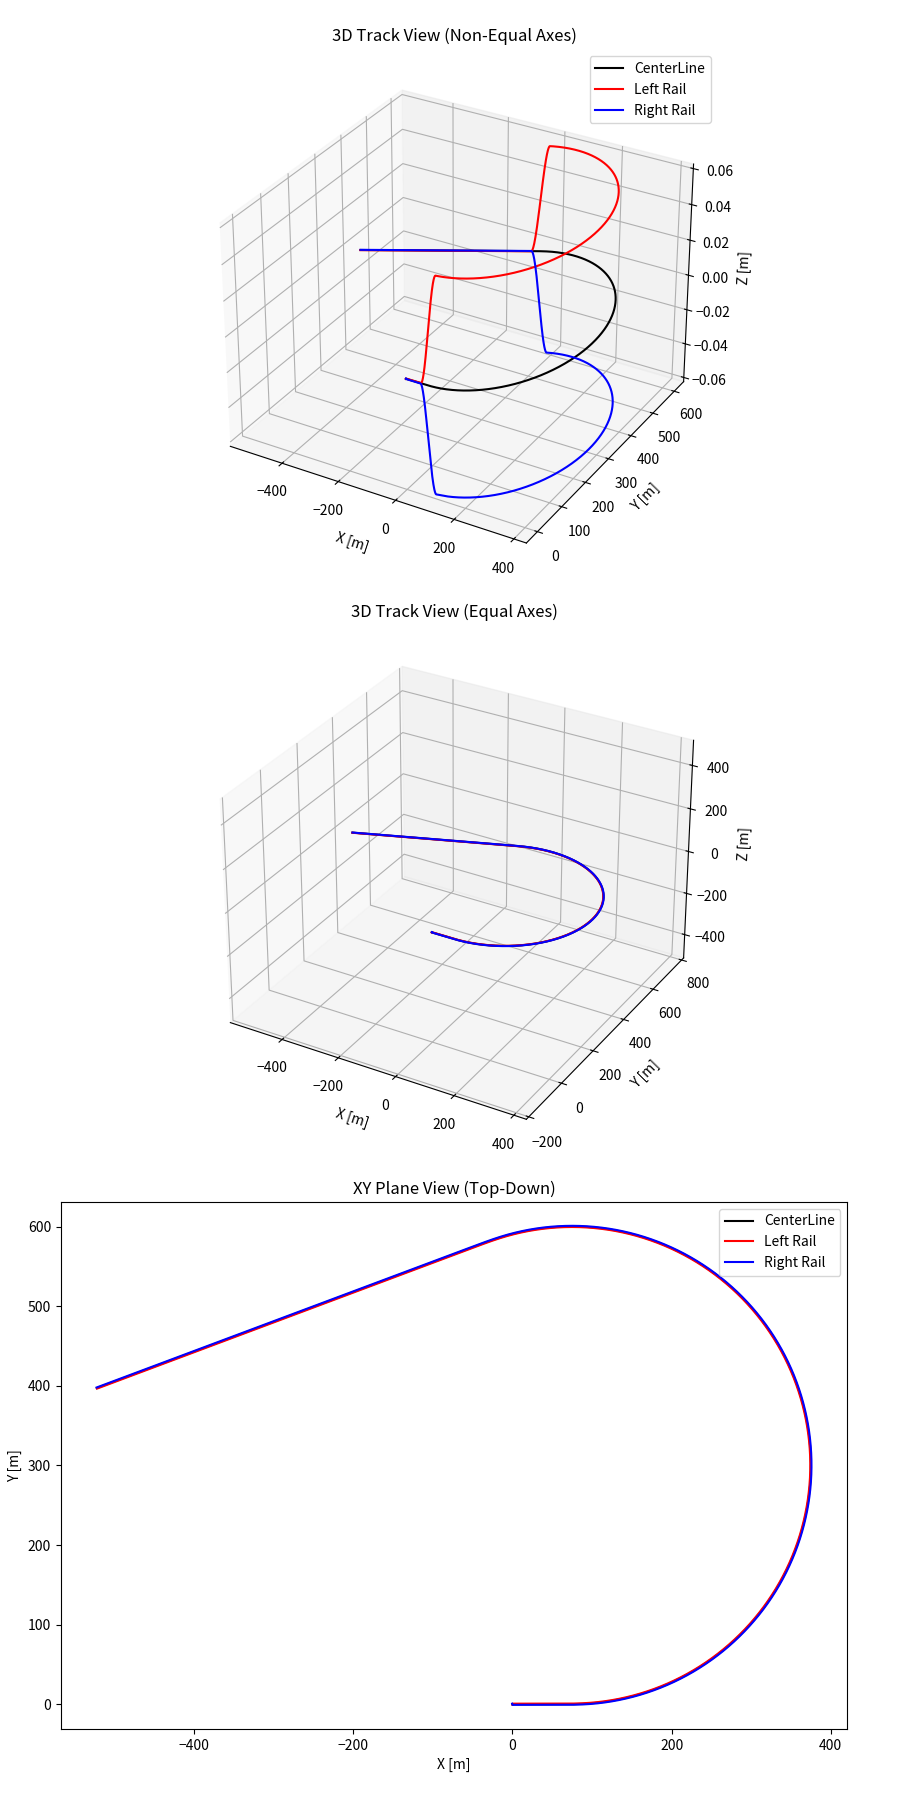

In [4]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Noto Sans CJK JP']

#===================== 1) 轨道段定义 =====================
#--- 水平方向 ---
h_segments = [
    ('STR',  50      ),            # 1.直线50m
    ('BLO',  50, 0.0, 300.0 ),     # 2.Bl.  0-->1/300
    ('CIR',1000, 300 ),           # 3.圆曲线 300m半径
    ('BLO',  50,300, 0 ),         # 4.Bl.  1/300-->0
    ('STR', 500     )             # 5.直线500m
]

#--- 超高方向 ---
u_segments = [
    ('CST', 50,   0.0),           # 常值超高 0
    ('BLO', 50, 0.0, 0.12),       # 从0变化到0.12
    ('CST',1000, 0.12),           # 保持0.12不变
    ('BLO', 50, 0.12, 0.0),       # 回到0
    ('CST', 500, 0.0 )
]

# 设定 smoothing 总长度(左右各1.5m)
L_smo = 3.0
half_smo = 1.5

# 轨距参考(中心线->左右钢轨边)   b_ref=1.5
b_ref = 1.5

#===================== 2) 计算各段的累积里程范围 =====================
def build_s_bounds(segments):
    s_bounds = [0.0]
    for seg in segments:
        L_ = seg[1]
        s_bounds.append(s_bounds[-1] + L_)
    return s_bounds

h_s_bounds = build_s_bounds(h_segments)
u_s_bounds = build_s_bounds(u_segments)

#===================== 3) 定义 '原始' 曲率 / 超高 的段函数 =====================
# -- 先写 "水平曲率kappa" raw formula --
def bloss_kappa_raw(srel, Lseg, R1, R2):
    k1 = 1.0/R1 if abs(R1)>1e-12 else 0.0
    k2 = 1.0/R2 if abs(R2)>1e-12 else 0.0
    x  = srel / Lseg
    return k1 + (k2 - k1)*(3*x**2 - 2*x**3)

def bloss_kappa_deriv_raw(srel, Lseg, R1, R2):
    k1 = 1.0/R1 if abs(R1)>1e-12 else 0.0
    k2 = 1.0/R2 if abs(R2)>1e-12 else 0.0
    dk = (k2 - k1)
    x  = srel / Lseg
    return dk*(6*x - 6*x**2)/Lseg

def bloss_kappa_2deriv_raw(srel, Lseg, R1, R2):
    k1 = 1.0/R1 if abs(R1)>1e-12 else 0.0
    k2 = 1.0/R2 if abs(R2)>1e-12 else 0.0
    dk = (k2 - k1)
    x  = srel / Lseg
    return dk*(6 - 12*x)/(Lseg**2)

def kappa_raw_formula(stype, Lseg, srel, params):
    """返回(k, k', k''), 未含smoothing."""
    if stype=='STR':
        return (0.0, 0.0, 0.0)
    elif stype=='CIR':
        R = params[0]
        k = 1.0/R if abs(R)>1e-12 else 0.0
        return (k, 0.0, 0.0)
    elif stype=='BLO':
        R1, R2 = params
        k  = bloss_kappa_raw(srel, Lseg, R1, R2)
        kp = bloss_kappa_deriv_raw(srel, Lseg, R1, R2)
        k2p= bloss_kappa_2deriv_raw(srel, Lseg, R1, R2)
        return (k, kp, k2p)
    return (0.0,0.0,0.0)  # 其他类型省略

# -- 再写 "超高u" raw formula；类似CST, LIR, BLO --
def bloss_u_raw(srel, Lseg, u1, u2):
    x = srel/Lseg
    return u1 + (u2 - u1)*(3*x**2 - 2*x**3)

def bloss_u_deriv_raw(srel, Lseg, u1, u2):
    x = srel/Lseg
    return (u2 - u1)*(6*x - 6*x**2)/Lseg

def bloss_u_2deriv_raw(srel, Lseg, u1, u2):
    x = srel/Lseg
    return (u2 - u1)*(6 -12*x)/(Lseg**2)

def u_raw_formula(stype, Lseg, srel, params):
    """返回(u, u', u''), 未含smoothing."""
    if stype=='CST':
        # params=(u0,)
        return (params[0], 0.0, 0.0)
    elif stype=='BLO':
        # params=(u1,u2)
        u1, u2 = params
        uu  = bloss_u_raw(srel, Lseg, u1, u2)
        up  = bloss_u_deriv_raw(srel, Lseg, u1, u2)
        upp = bloss_u_2deriv_raw(srel, Lseg, u1, u2)
        return (uu, up, upp)
    elif stype=='CIR':
        # 例如若有人想做常值段，也可以CST；这里暂不实现CIR=BLO等
        return (params[0], 0.0, 0.0)
    return (0.0,0.0,0.0)

#===================== 4) 构造 5次多项式拼接(smoothing) 的通用函数 =====================
def poly5_val(x, c):
    return c[0] + c[1]*x + c[2]*x**2 + c[3]*x**3 + c[4]*x**4 + c[5]*x**5
def poly5_d1(x, c):
    return c[1] + 2*c[2]*x + 3*c[3]*x**2 + 4*c[4]*x**3 + 5*c[5]*x**4
def poly5_d2(x, c):
    return 2*c[2] + 6*c[3]*x + 12*c[4]*x**2 + 20*c[5]*x**3

def solve_poly5_smoothing(kL,kLp,kLpp, kR,kRp,kRpp, dist):
    """
    在区间 x in [0, dist] 上用5次多项式插值，
    使其在x=0时 p=kL, p'=kLp, p''=kLpp,
           x=dist时 p=kR, p'=kRp, p''=kRpp.
    返回系数 c[0..5].
    """
    M = np.zeros((6,6), dtype=float)
    b = np.zeros(6, dtype=float)

    def p_vec(x):
        return np.array([1, x, x**2, x**3, x**4, x**5], dtype=float)
    def dp_vec(x):
        return np.array([0, 1, 2*x, 3*x**2, 4*x**3, 5*x**4], dtype=float)
    def ddp_vec(x):
        return np.array([0, 0, 2, 6*x, 12*x**2, 20*x**3], dtype=float)

    # 左端
    M[0,:] = p_vec(0.0);   b[0] = kL
    M[1,:] = dp_vec(0.0);  b[1] = kLp
    M[2,:] = ddp_vec(0.0); b[2] = kLpp

    # 右端
    M[3,:] = p_vec(dist);   b[3] = kR
    M[4,:] = dp_vec(dist);  b[4] = kRp
    M[5,:] = ddp_vec(dist); b[5] = kRpp

    coefs = np.linalg.solve(M,b)
    return coefs

#===================== 5) 构造通用的“分段 + smoothing”拼接器 =====================
def build_piecewise_function(segments, s_bounds, raw_func):
    """
    给定:
      segments: [ (stype, L, [params...]), ... ]
      s_bounds: [s0, s1, s2, ...]  (累积里程)
      raw_func: 返回 (val, val', val'')

    返回: pieces(list), 用于在区间 [0, s_bounds[-1]] 内 piecewise 评估
    """
    num_segs = len(segments)
    ps = []  # pieces

    for i in range(num_segs):
        s0 = s_bounds[i]
        s1 = s_bounds[i+1]
        Lseg = s1 - s0

        has_left_smo = (i>0)
        has_right_smo= (i<num_segs-1)

        # (1) 左平滑段
        if has_left_smo and Lseg>half_smo:
            # 上一段在 local_s = L_{prev} 处
            s_prev0 = s_bounds[i-1]
            s_prev1 = s_bounds[i]
            L_prev  = s_prev1 - s_prev0

            # left boundary condition = prev段 raw @ local_s = L_prev
            stype0 = segments[i-1][0]
            L0     = segments[i-1][1]
            params0= segments[i-1][2:]
            kL, kLp, kLpp = raw_func(stype0, L0, L0, params0)

            # right boundary = 本段 raw @ local_s=half_smo
            stype1 = segments[i][0]
            L1     = segments[i][1]
            params1= segments[i][2:]
            kR, kRp, kRpp = raw_func(stype1, L1, half_smo, params1)

            dist = half_smo
            coefs = solve_poly5_smoothing(kL,kLp,kLpp, kR,kRp,kRpp, dist)

            ps.append({
                's_min': s0,
                's_max': s0+half_smo,
                'type': 'poly_smooth',
                'coefs': coefs,
                'dist': dist
            })
            left_raw_start = s0+half_smo
        else:
            left_raw_start = s0

        # (2) 中间 raw 段
        if has_right_smo and Lseg>half_smo:
            right_raw_end = s1 - half_smo
        else:
            right_raw_end = s1

        if right_raw_end>left_raw_start+1e-12:
            ps.append({
                's_min': left_raw_start,
                's_max': right_raw_end,
                'type': 'raw',
                'seg_id': i
            })

        # (3) 右平滑段
        if has_right_smo and Lseg>half_smo:
            # left boundary = 本段 raw@ local_s=(Lseg - half_smo)
            stype1 = segments[i][0]
            L1     = segments[i][1]
            params1= segments[i][2:]
            kL, kLp, kLpp = raw_func(stype1, L1, L1 - half_smo, params1)

            # right boundary = 下段 raw@ local_s=0
            stype2 = segments[i+1][0]
            L2     = segments[i+1][1]
            params2= segments[i+1][2:]
            kR, kRp, kRpp = raw_func(stype2, L2, 0.0, params2)

            dist = half_smo
            coefs = solve_poly5_smoothing(kL,kLp,kLpp, kR,kRp,kRpp, dist)

            ps.append({
                's_min': s1 - half_smo,
                's_max': s1,
                'type': 'poly_smooth',
                'coefs': coefs,
                'dist': dist
            })

    # 记录下：segments 本身 (后面 raw段时要用)
    return ps

#===================== 6) 生成 piecewise 并写出全局eval函数 =====================
h_pieces = build_piecewise_function(h_segments, h_s_bounds,
    lambda stype,Lseg,srel,pm: kappa_raw_formula(stype,Lseg,srel,pm) )

u_pieces = build_piecewise_function(u_segments, u_s_bounds,
    lambda stype,Lseg,srel,pm: u_raw_formula(stype,Lseg,srel,pm) )

def eval_piecewise(s, pieces, segments, raw_func):
    # 超出范围
    if s<0: return 0.0
    if s>max(p['s_max'] for p in pieces): 
        return 0.0
    # 找到piece
    for p in pieces:
        if s>=p['s_min'] and s<=p['s_max']+1e-12:
            if p['type']=='raw':
                i_seg = p['seg_id']
                s0    = s_bounds = 0.0  # 准备
                segLen= segments[i_seg][1]
                s_base= s_bounds = 0.0  # 先找出这段的全局起点
                # 其实可以从 s_pieces[] 里推算，这里演示简化做法:
                seg_global_start = 0.0 + sum(x[1] for x in segments[:i_seg])
                srel = s - seg_global_start
                # 避免负值
                if srel<0: srel=0
                if srel>segLen: srel=segLen

                stype = segments[i_seg][0]
                pm    = segments[i_seg][2:]
                return raw_func(stype, segLen, srel, pm)[0]  # val
            else:
                # poly_smooth
                coefs= p['coefs']
                x_   = s - p['s_min']
                return poly5_val(x_, coefs)
    return 0.0

# 为了简化，这里我们可以专门写 kappa(s)、u(s)：
def Kappa(s):
    return eval_piecewise(s, h_pieces, h_segments, kappa_raw_formula)

def U(s):
    return eval_piecewise(s, u_pieces, u_segments, u_raw_formula)

#===================== 7) 用数值积分求 (x(s),y(s),z(s)) =====================
ds=0.1
s_end = h_s_bounds[-1]  # 1650
s_vals = np.arange(0, s_end+ds*0.1, ds)

xvals=[0.0]
yvals=[0.0]
zvals=[0.0]  # 暂不考虑坡度 => z=0
psi= 0.0
psi_vals= [0.0]

for i in range(1, len(s_vals)):
    sA = s_vals[i-1]
    sB = s_vals[i]
    sM = 0.5*(sA+sB)
    kM = Kappa(sM)
    ds_ = (sB-sA)
    psi_new = psi + kM*ds_
    # 中点法
    x_new = xvals[-1] + ds_*np.cos(psi + 0.5*kM*ds_)
    y_new = yvals[-1] + ds_*np.sin(psi + 0.5*kM*ds_)
    z_new = zvals[-1]  # 无坡度
    xvals.append(x_new)
    yvals.append(y_new)
    zvals.append(z_new)
    psi_vals.append(psi_new)

    psi= psi_new

# 转成 array
xvals= np.array(xvals)
yvals= np.array(yvals)
zvals= np.array(zvals)
psi_vals = np.array(psi_vals)

# 计算 phi(s) = arcsin(u(s)/b_ref)
phi_vals=[]
for s_ in s_vals:
    u_ = U(s_)
    phi_= np.arcsin( u_/ b_ref )  # about centerline
    phi_vals.append(phi_)
phi_vals = np.array(phi_vals)

#===================== 8) 生成左右钢轨 3D 坐标并绘图 =====================
left_rail  = []
right_rail = []

for i in range(len(s_vals)):
    xC = xvals[i]
    yC = yvals[i]
    zC = zvals[i]
    psi_ = psi if i==0 else np.arctan2( yvals[i]-yvals[i-1], xvals[i]-xvals[i-1] )
    # 上面也可直接用我们积分得到的 psi, 这里简单做法(或者存储前面循环中的 psi 也行)
    # 不过更精确的是保留在循环里更新的 psi

    psi_ = psi_  # already in [0..2pi]
    phi_ = phi_vals[i]

    half_b = 0.5*b_ref
    # 这里的 z_shift = (b_ref/2)* sin(phi)
    z_shift = half_b*np.sin(phi_)
    
    # 假设 local Y= +b_ref/2 => 旋转到全局
    dxL =  half_b * (-np.sin(psi_))
    dyL =  half_b * ( np.cos(psi_))
    xL  =  xC + dxL
    yL  =  yC + dyL
    zL  =  zC + z_shift

    # 右股钢轨
    dxR = -half_b * (-np.sin(psi_))
    dyR = -half_b * ( np.cos(psi_))
    xR  = xC + dxR
    yR  = yC + dyR
    zR  = zC - z_shift

    left_rail.append((xL,yL,zL))
    right_rail.append((xR,yR,zR))

left_rail  = np.array(left_rail)
right_rail = np.array(right_rail)

# 存储/返回最终数组
# 把 s_vals[i] xvals[i], yvals[i], zvals[i] psi_vals[i] phi_vals[i]
# 将所有数组合并为一个字典，保存为单个.npz文件
trajectory_data = {
    's': s_vals,
    'x': xvals,
    'y': yvals,
    'z': zvals,
    'psi': psi_vals,
    'phi': phi_vals,
    'left_rail': left_rail,
    'right_rail': right_rail
}
np.savez('trajectory_data.npz', **trajectory_data)

# 作图
fig = plt.figure(figsize=(9, 18))

#----- (1) 3D视图(不等比例) -----
ax1 = fig.add_subplot(311, projection='3d')
ax1.plot(xvals, yvals, zvals, 'k-', label='CenterLine')
ax1.plot(left_rail[:,0], left_rail[:,1], left_rail[:,2], 'r-', label='Left Rail')
ax1.plot(right_rail[:,0], right_rail[:,1], right_rail[:,2], 'b-', label='Right Rail')
ax1.set_title("3D Track View (Non-Equal Axes)")
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")
ax1.set_zlabel("Z [m]")
ax1.legend()

#----- (2) 3D视图(等比例) -----
ax2 = fig.add_subplot(312, projection='3d')
ax2.plot(xvals, yvals, zvals, 'k-')
ax2.plot(left_rail[:,0], left_rail[:,1], left_rail[:,2], 'r-')
ax2.plot(right_rail[:,0], right_rail[:,1], right_rail[:,2], 'b-')
ax2.set_title("3D Track View (Equal Axes)")
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")
ax2.set_zlabel("Z [m]")

# 强制坐标轴等比例
x_limits = ax2.get_xlim3d()
y_limits = ax2.get_ylim3d()
z_limits = ax2.get_zlim3d()
x_range = abs(x_limits[1] - x_limits[0])
y_range = abs(y_limits[1] - y_limits[0])
z_range = abs(z_limits[1] - z_limits[0])
max_range = max(x_range, y_range, z_range)
mid_x = 0.5*(x_limits[0]+x_limits[1])
mid_y = 0.5*(y_limits[0]+y_limits[1])
mid_z = 0.5*(z_limits[0]+z_limits[1])
ax2.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
ax2.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
ax2.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

#----- (3) XY平面俯视图(2D) -----
ax3 = fig.add_subplot(313)
ax3.plot(xvals, yvals, 'k-', label='CenterLine')
ax3.plot(left_rail[:,0], left_rail[:,1], 'r-', label='Left Rail')
ax3.plot(right_rail[:,0], right_rail[:,1], 'b-', label='Right Rail')
ax3.set_aspect('equal')
ax3.set_title("XY Plane View (Top-Down)")
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Y [m]")
ax3.legend()

plt.tight_layout(pad=2.0)
plt.show()

# 自主作图与 SIMPACK 原始数据对比
- SIMPACK GUI 之中，轨道平面图之中，Y在横坐标，X在纵坐标
- SPCK 导出的水平直线与曲线线路分布的数据文件: TrkHorizontal_R300m60kmph_Vehicle4WDB.txt

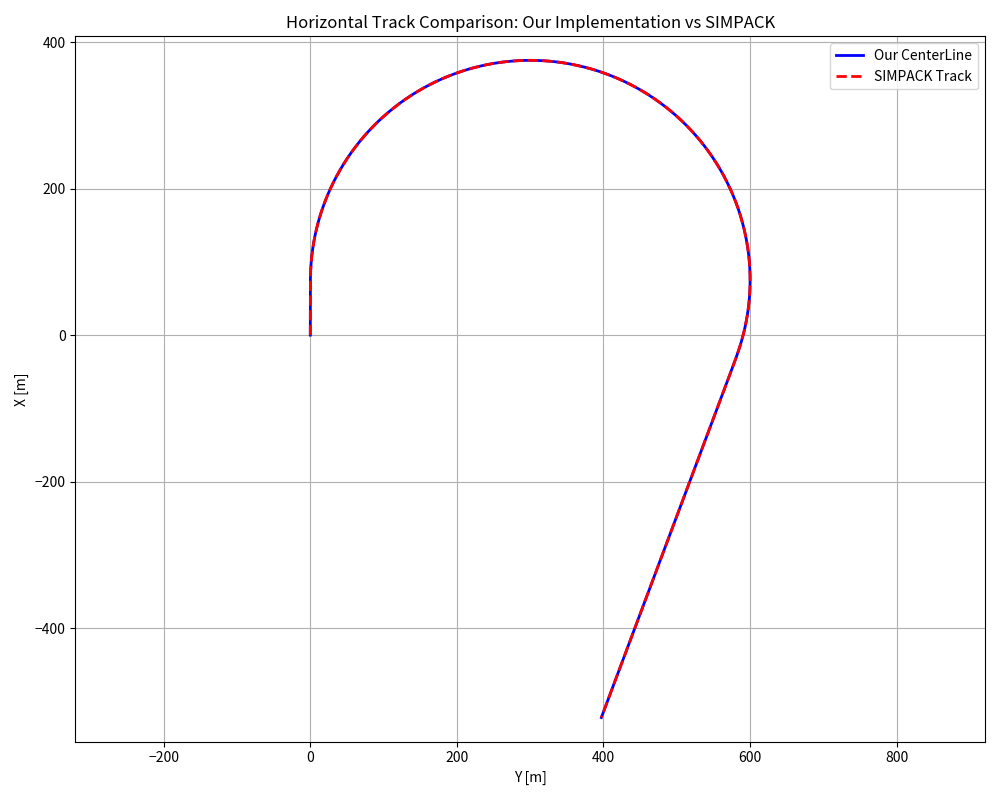

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 假设我们已经有上述代码计算得到的变量
# left_rail, right_rail, xvals, yvals 等已经定义好

# 读取SIMPACK原生的轨道数据
def read_track_data(filename):
    # 使用更健壮的方法读取数据
    # 首先以文本方式读取文件
    with open(filename, 'r') as f:
        lines = f.readlines()[4:]  # 跳过前4行说明文字
    
    # 初始化存储数据的列表
    splined_track_x = []
    splined_track_y = []
    
    for line in lines:
        parts = line.strip().split(',')
        if len(parts) >= 2:  # 确保行至少有2列
            try:
                # 尝试转换为浮点数，对空字符串使用默认值
                x_val = float(parts[0]) if parts[0].strip() else 0.0
                y_val = float(parts[1]) if parts[1].strip() else 0.0
                
                # 检查值是否为极小的科学计数法（可能是无效数据）
                if abs(x_val) < 1e-100:
                    x_val = 0.0
                
                splined_track_x.append(x_val)
                splined_track_y.append(y_val)
            except ValueError as e:
                print(f"无法转换行: {line.strip()}, 错误: {e}")
                continue
    
    return np.array(splined_track_x), np.array(splined_track_y)
    
# 读取SIMPACK轨道数据
simpack_file = '/home/yaoyao/Documents/myProjects/ROS2WithSPCK/SPCK_Track/TrkHorizontal_R300m60kmph_Vehicle4WDB.txt'
splined_track_x, splined_track_y = read_track_data(simpack_file)

# 创建独立的图形来对比数据
plt.figure(figsize=(10, 8))
plt.plot(yvals, xvals, 'b-', linewidth=2, label='Our CenterLine')
plt.plot(splined_track_x, splined_track_y, 'r--', linewidth=2, label='SIMPACK Track')

plt.xlabel("Y [m]")
plt.ylabel("X [m]")
plt.title("Horizontal Track Comparison: Our Implementation vs SIMPACK")
plt.legend()
plt.axis('equal')  # 设置坐标轴等比例
plt.grid(True)     # 增加网格线
plt.tight_layout()
plt.show()

# SIMPACK超高轨道数据可视化
- 红色为 SPCK 导出
- 蓝色为自定义曲线
- 两者有极小误差, 小于 2e-5 m（0.02 mm）
- SPCK 导出的超高随线路延伸的数据文件: TrkSuperlev_R300m60kmph_Vehicle4WDB.txt

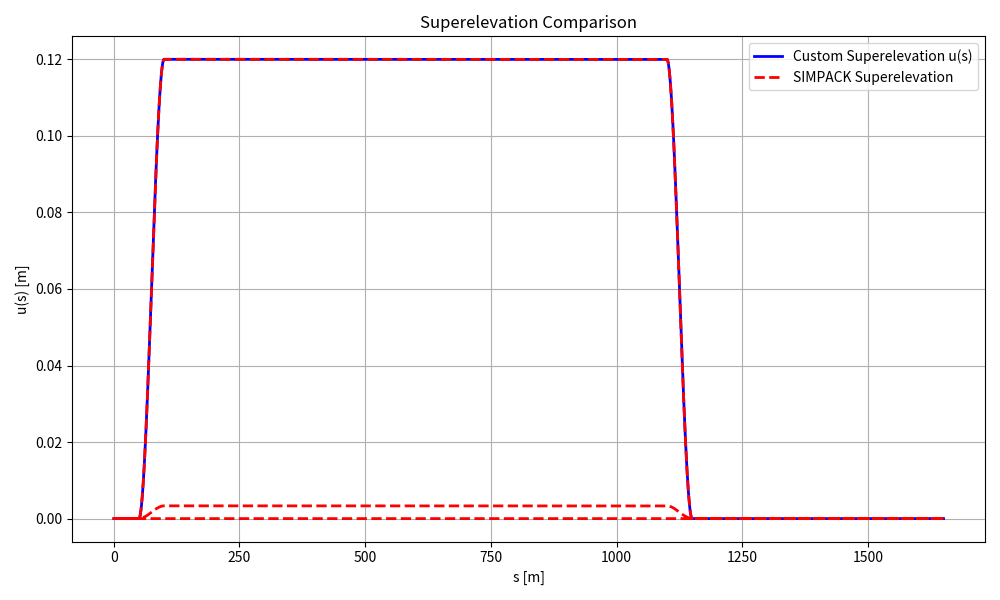

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 从SIMPACK文件读取轨道数据的函数
def read_track_data(filename):
    # 用于存储数据的列表
    splined_track_x = []
    splined_track_y = []
    
    try:
        # 跳过前4行，从第5行开始读取数据
        with open(filename, 'r') as f:
            # 跳过前4行
            for _ in range(4):
                next(f)
            
            # 读取其余行
            for line in f:
                parts = line.strip().split(',')
                if len(parts) >= 2:  # 确保行至少有2列
                    try:
                        # 尝试转换为浮点数，对空字符串使用默认值
                        x_val = float(parts[0]) if parts[0].strip() else 0.0
                        y_val = float(parts[1]) if parts[1].strip() else 0.0
                        
                        # 检查值是否为极小的科学计数法（可能是无效数据）
                        if abs(y_val) < 1e-100:
                            y_val = 0.0
                        if abs(x_val) < 1e-100:
                            x_val = 0.0
                            
                        splined_track_x.append(x_val)
                        splined_track_y.append(y_val)
                    except ValueError:
                        # 如果无法转换，则跳过该行，但不打印错误信息
                        continue
    except Exception as e:
        print(f"读取文件时出错: {e}")
        return np.array([]), np.array([])
    
    return np.array(splined_track_x), np.array(splined_track_y)

# Use the U(s) function already defined in your original code
# (No need to redefine it here)

# 定义轨道参数
h_s_bounds = [1650]  # 轨道总长，例如1650m
ds = 0.1

# 1. 生成要绘图的 s 序列
s_end = h_s_bounds[-1]
s_vals = np.arange(0, s_end + ds*0.1, ds)

# 2. 对每个 s 计算超高 u(s)
u_vals = [U(s) for s in s_vals]

# 读取SIMPACK超高轨道数据
superlev_file = '/home/yaoyao/Documents/myProjects/ROS2WithSPCK/SPCK_Track/TrkSuperlev_R300m60kmph_Vehicle4WDB.txt'
splined_track_x, splined_track_y = read_track_data(superlev_file)

# 检查是否成功读取数据
if len(splined_track_x) == 0 or len(splined_track_y) == 0:
    print("无法读取有效数据！")
else:
    # 3. 创建组合的 "u(s) - s" 图
    plt.figure(figsize=(10, 6))
    
    # 用蓝色绘制自定义曲线
    plt.plot(s_vals, u_vals, 'b-', linewidth=2, label='Custom Superelevation u(s)')
    
    # 用红色虚线绘制SIMPACK数据以提高可见性逆向
    plt.plot(splined_track_x, splined_track_y, 'r--', linewidth=2, label='SIMPACK Superelevation')
    
    # 保持图例和标签为英文
    plt.title("Superelevation Comparison")
    plt.xlabel("s [m]")
    plt.ylabel("u(s) [m]")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
